# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

**Признаки:**

- DateCrawled — дата скачивания анкеты из базы

- VehicleType — тип автомобильного кузова

- RegistrationYear — год регистрации автомобиля

- Gearbox — тип коробки передач

- Power — мощность (л. с.)

- Model — модель автомобиля

- Kilometer — пробег (км)

- RegistrationMonth — месяц регистрации автомобиля

- FuelType — тип топлива

- Brand — марка автомобиля

- Repaired — была машина в ремонте или нет

- DateCreated — дата создания анкеты

- NumberOfPictures — количество фотографий автомобиля

- PostalCode — почтовый индекс владельца анкеты (пользователя)

- LastSeen — дата последней активности пользователя

**Целевой признак:**

- Price — цена (евро)

**Задачи:**


- Загрузить,подготовить и исследовать данные.


- Обучить разные модели.


- Проанализировать скорость работы и качество моделей.


- Выбрать наулилучшую модель по 3 параметрам: качество, скорость и время обучения.

## Подготовка данных

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

import time

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import category_encoders as ce
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Lasso
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/autos.csv')

In [4]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Найдем и удалим дубликаты:

In [6]:
df.duplicated().sum()

4

In [7]:
df.drop_duplicates(inplace=True)

Посмотрим на пропуски в данных:

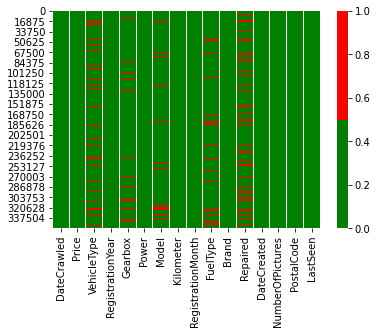

In [8]:
colours = ['#008000', '#FF0000']
sns.heatmap(df.isna(), cmap = sns.color_palette(colours));

In [9]:
df.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Удалим столбцы, не несущие полезной информации для анализа:

In [10]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [11]:
numeric = ['DateCreated', 'Price', 'RegistrationYear', 'Power', 'Kilometer', 'LastSeen']
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired', 'Brand']

### Вывод после ознакомления с данными:

1) В датасете 16 столбцов, 7 имеют тип int, 9 object

2) В данных присутствуют пропуски(В 4 столбцах: VehicleType, Gearbox, Model, FuelType, NotRepaired много пропущенных значений), в столбце Repaired их количество составляет 20%. Причина неясна.

3) В столбце RegistrationYear есть аномальные значения, а именно, минимальный год выпуска 1000 год, а максимальный 9999.

4) В столбце Power минимальное значение 0. Максимальное значение 20 тысяч, что выглядит нереально.

5) В столбце Price есть аномальное значение  "0".

6) В столбце Kilometer слишком округлённые значения и максимальные значение 150 000 км, учитывая, что в выборке есть автомобили прошлого тысячелетия. Скорее всего при заполнении объявления на сайте есть готовые шаблоны.


### Первичная предобработка

Посмотрим, когда было подано первое объявление:

In [12]:
f"Минимальная дата рагистрации объявления: {min(df['DateCreated'])}"

'Минимальная дата рагистрации объявления: 2014-03-10 00:00:00'

Преобразуем столбцы DateCreated и LastSeen в количество дней с первого объявления:

In [13]:
base_date = pd.Timestamp('2014-03-10 00:00:00')
df['DateCreated'] = df['DateCreated'].map(lambda date : (pd.Timestamp(date) - base_date).days)

In [14]:
df['LastSeen'] = df['LastSeen'].map(lambda date : (pd.Timestamp(date) - base_date).days)

Посмотрим, сколько объявлений у нас нулевой ценой:

In [15]:
df[df['Price'] == 0]['Price'].count()

10772

In [16]:
 round(df[df['Price'] == 0].shape[0] / df.shape[0] * 100)

3

Получается, что 3% объявлений имеют нулевую цену, удалим их:

In [17]:
df = df.loc[df['Price'] != 0]

Определим функцию для построения распределения:

In [18]:
def draw_distribution(df, x, x_label, y_label, title, bins):
    plt.figure(figsize=(12, 8))
    sns.histplot(data=df, x=x, kde=True, bins=bins)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=x)
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()

Построим распределение цены:

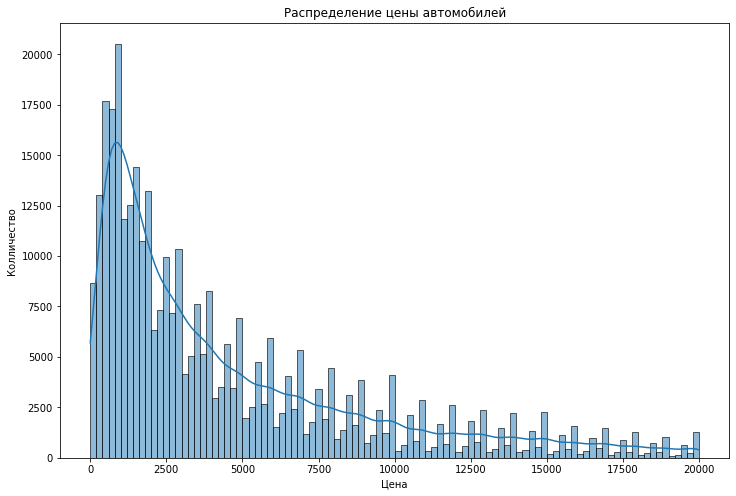

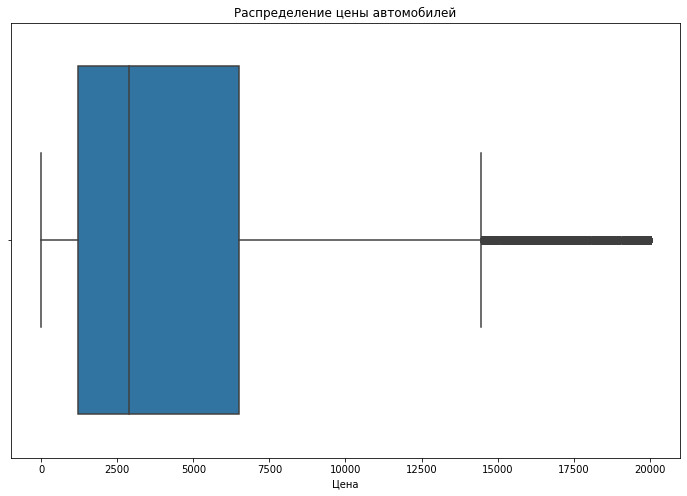

In [19]:
draw_distribution(df, 'Price', 'Цена', 'Колличество', 'Распределение цены автомобилей', 100)

**Вывод:** у нас наблюдается правый хвост, а большинство предложений имеют цену до 6 тысяч. Также можно заметить, что продавцы любят выставлять ровную цену, кратную 500 или 1000.

Изучим столбец Model:

In [20]:
f"Количество объявлений с незаполненной моделью: {len(df.loc[df['Model'].isna()])}"

'Количество объявлений с незаполненной моделью: 17521'

Не так много. Учитывая, что модель говорит об автомобиле больше всего, и это ключевой признак для формирования цены, который нет возможности заполнить, просто удалим пропуски:

In [21]:
df = df.loc[~df['Model'].isna()]

Для построения высокоточной модели было бы неплохо избавиться от аномальных значений. Посмотрим, много ли объявлений с автомобилями старше 60 лет:

In [22]:
df[df['RegistrationYear'] < 1960].RegistrationYear.value_counts()

1910    25
1959    16
1000    15
1950    13
1956    13
1958    12
1955     9
1957     9
1951     8
1953     8
1937     7
1954     6
1929     4
1952     4
1945     3
1943     3
1938     3
1800     3
1936     3
1932     3
1300     2
1942     2
1934     2
1933     2
1947     2
1930     2
1928     2
1923     2
1234     2
1500     2
1935     2
1941     1
1949     1
1931     1
1927     1
1400     1
1602     1
1600     1
1001     1
Name: RegistrationYear, dtype: int64

**Вывод:** Несмотря на присутствие объявлений со старыми автомобилями(раритетными?), мы удалим их, поскольку нам важнее высокая предсказательная способность модели для среднего автомобиля. А коллекционные авто пусть анализируются на специальных порталах или специалистами(это штучный товар).

In [23]:
df = df.loc[(df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] <= 2016)]

Построим распределение мощности двигателя:

In [24]:
Power = df.loc[df['Power'] < 1000]

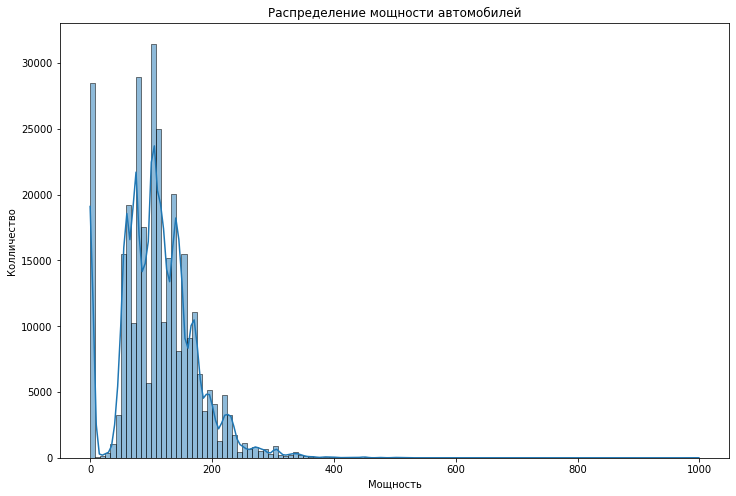

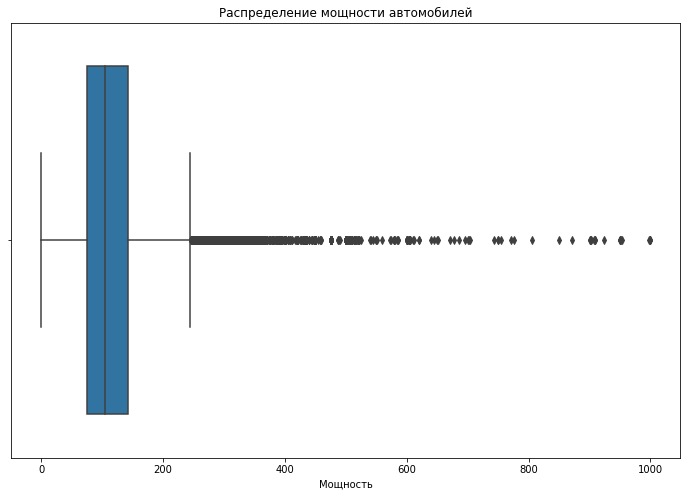

In [25]:
draw_distribution(Power, 'Power', 'Мощность', 'Колличество', 'Распределение мощности автомобилей', 120)

**Вывод:** Практически нет автомобилей с мощностью выше 400 л.с., а подавляющее большинство лежит в пределах 250. Также есть аномальный пик с мощностью 0. Поскольку машина с нулевой мощностью явно не поедет, а исправить эти значения нет возможности, оставим в датасете объявления с мощностью в диапазоне от 30 до 600.

In [26]:
df = df.loc[(df['Power'] >= 30) & (df['Power'] <= 600)]

Посмотрим на пробег:

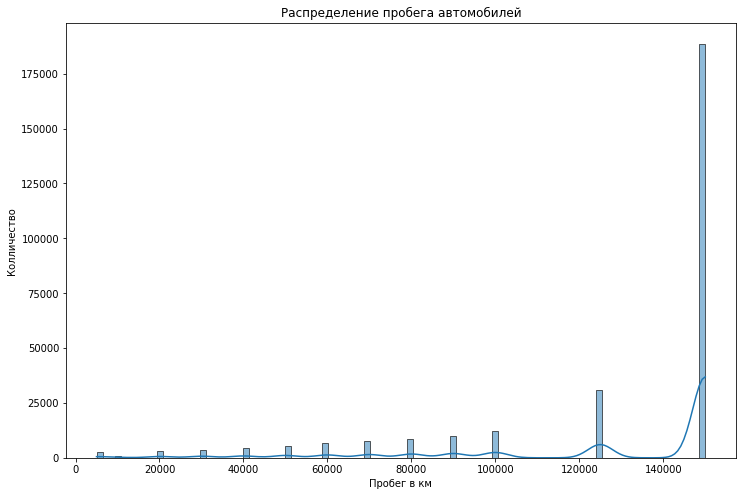

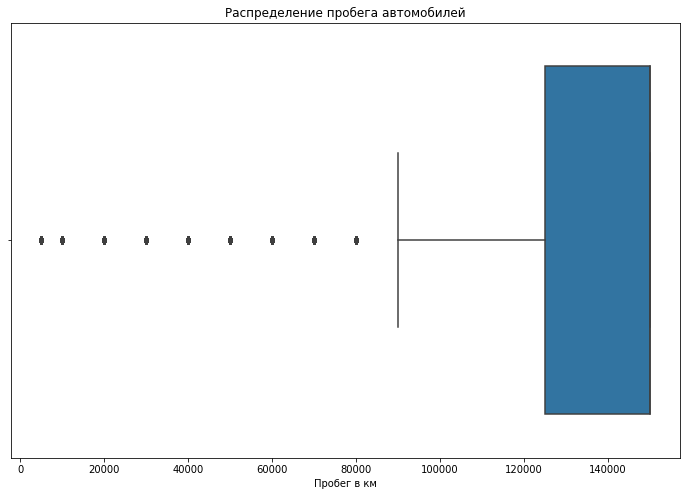

In [27]:
draw_distribution(df, 'Kilometer', 'Пробег в км', 'Колличество', 'Распределение пробега автомобилей', 100)

**Вывод**: огромный пик в районе 150 тыс.км. Наверняка это максимальное значение, которое можно ввести на сайте, и все машины, имеющие пробег больше попадают в эту категорию.

**Теперь заполним пропуски:**

In [28]:
df.isnull().sum()

Price                   0
VehicleType          9420
RegistrationYear        0
Gearbox              4644
Power                   0
Model                   0
Kilometer               0
FuelType            12830
Brand                   0
Repaired            39034
DateCreated             0
LastSeen                0
dtype: int64

In [29]:
df.Gearbox.value_counts(normalize=True)

manual    0.797949
auto      0.202051
Name: Gearbox, dtype: float64

Заменим пропуски для коробки передач на other:

In [30]:
df.Gearbox = df.Gearbox.fillna('other')

Для столбцов FuelType, Repaired, VehicleType - пропуски заменим на 'unknown':

In [31]:
df.FuelType = df.FuelType.fillna('unknown') 
df.Repaired = df.Repaired.fillna('unknown')
df.VehicleType = df.VehicleType.fillna('unknown')

In [32]:
df.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
DateCreated         0
LastSeen            0
dtype: int64

**Вывод:** пропусков не осталось переходим к следующему этапу.

## Кодировка данных

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284767 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             284767 non-null  int64 
 1   VehicleType       284767 non-null  object
 2   RegistrationYear  284767 non-null  int64 
 3   Gearbox           284767 non-null  object
 4   Power             284767 non-null  int64 
 5   Model             284767 non-null  object
 6   Kilometer         284767 non-null  int64 
 7   FuelType          284767 non-null  object
 8   Brand             284767 non-null  object
 9   Repaired          284767 non-null  object
 10  DateCreated       284767 non-null  int64 
 11  LastSeen          284767 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 28.2+ MB


Разделим датасет на обучающую и тестовую выборки:

In [34]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop(['Price'], axis=1), df['Price'], test_size=0.25, random_state=123)

Перекодируем категориальные признаки:

In [35]:
ce_ord = ce.OrdinalEncoder(cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'])
features_train = ce_ord.fit_transform(features_train, target_train)
features_test = ce_ord.transform(features_test, target_test)

Масштабируем признаки:

In [36]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

## Обучение и анализ моделей

Определим функцию для ключевой метрики:

In [37]:
def RMSE(target,predictions):
    MSE = mean_squared_error(target, predictions)
    return MSE ** 0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)

Определим фунцкию для подбора парметров и вычисления лучшей модели:

In [38]:
def best_model(model, params, features_train, target_train, features_test, target_test):
    grid = GridSearchCV(model, param_grid = params, cv=2,
                                            scoring = RMSE_score, n_jobs=-1)
    grid.fit(features_train,target_train)
    results = pd.DataFrame(grid.cv_results_).sort_values(by = 'rank_test_score')
    predict = grid.predict(features_test)
    fit_time = results.iloc[0]['mean_fit_time']
    predict_time = results.iloc[0]['mean_score_time']
    return fit_time, predict_time, -grid.best_score_ , grid.best_params_ 

Посмотрим на Лассо модели как работает наша функция:

In [39]:
lasso_model = Lasso(random_state=123)
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}

In [40]:
lasso = best_model(lasso_model, lasso_params, features_train, target_train, features_test, target_test)

In [41]:
lasso

(0.1352548599243164, 0.10194730758666992, 2924.9987568446695, {'alpha': 0.02})

Отлично, на выходе у нас получается время обучения, время предсказания и наша метрика. Попробуем с другими моделями

Обучим LGBM модель

In [42]:
lgbm_params = {
    'n_estimators': [10,50,100],
    'learning_rate': [0.4]
}
lgbm_reg_model = LGBMRegressor(random_state=123)

In [43]:
lgbm = best_model(lgbm_reg_model, lgbm_params, features_train, target_train, features_test, target_test)

In [44]:
lgbm

(2.686684012413025,
 0.6563955545425415,
 1583.615577693046,
 {'learning_rate': 0.4, 'n_estimators': 100})

Обучим CatBoost модель:

In [45]:
catboost_params = {
    'learning_rate': [0.1],
    'iterations': [10,50,100],
    'max_depth': [10,20]}
catboost_model = CatBoostRegressor(random_state=123,silent=True)

In [46]:
CatBoost = best_model(catboost_model, catboost_params, features_train, target_train, features_test, target_test)

In [47]:
CatBoost

(4.530676960945129,
 0.3449549674987793,
 1649.509524910655,
 {'iterations': 100, 'learning_rate': 0.1, 'max_depth': 10})

Обучим RandomForest модель:

In [48]:
RF_model = RandomForestRegressor(random_state=123)
forestregressor_params = {'n_estimators':range(10, 21, 10),
             'max_depth':range (1,5)}

In [49]:
RandomForest = best_model(RF_model, forestregressor_params, features_train, target_train, features_test, target_test)

In [50]:
RandomForest

(1.683653712272644,
 0.06889915466308594,
 2548.5232456246845,
 {'max_depth': 4, 'n_estimators': 20})

Обучим DecisionTree модель:

In [51]:
DT_model = DecisionTreeRegressor(random_state=123)
treeregressor_params = {'max_depth':range (1,10)}
DecisionTrees = best_model(DT_model, treeregressor_params, features_train, target_train, features_test, target_test)

In [52]:
DecisionTrees

(0.26281583309173584,
 0.01149129867553711,
 2037.7350596779947,
 {'max_depth': 9})

Обучим константную модель:

In [53]:
constant_model = DummyRegressor(strategy='mean')

In [54]:
constant_model.fit(features_train,target_train)
constant_pred = constant_model.predict(features_test)
RMSE(target_test,constant_pred)

4606.8237240218405

Выведем таблицу с параметрами быстродействия и метрики для всех моделей:

In [55]:
Models = pd.DataFrame([lasso, lgbm, CatBoost, RandomForest, DecisionTrees], 
             columns=['Время обучения', 'Время предсказания', 'RMSE', 'Лучшие Параметры'], 
                      index=['Lasso','LGBM','CatBoost', 'RandomForest', 'DecisionTrees'])

In [56]:
Models

,Время обучения,Время предсказания,RMSE,Лучшие Параметры
Lasso,0.135255,0.101947,2924.998757,{'alpha': 0.02}
LGBM,2.686684,0.656396,1583.615578,"{'learning_rate': 0.4, 'n_estimators': 100}"
CatBoost,4.530677,0.344955,1649.509525,"{'iterations': 100, 'learning_rate': 0.1, 'max..."
RandomForest,1.683654,0.068899,2548.523246,"{'max_depth': 4, 'n_estimators': 20}"
DecisionTrees,0.262816,0.011491,2037.735060,{'max_depth': 9}


**Вывод:** Лучшую метрику имеет модель LGBM - 1583 за 2,7 секунды, и она достаточно быстро обучается, на втором месте CatBoost - 1649 за 4,5 секунды секунд. Модели Lasso, RandomForest и DecisionTree обучаются быстро, но имеют меньшую точность. Все модели намного превзошли константную модель. 

Проверим модель LGBM на тестовой выборке:

In [57]:
lgbm = LGBMRegressor(learning_rate=0.4, n_estimators=100, random_state=123)

In [58]:
lgbm.fit(features_train, target_train)

LGBMRegressor(learning_rate=0.4, random_state=123)

In [59]:
predictions = lgbm.predict(features_test)

In [60]:
Rmse = RMSE(target_test, predictions)

In [61]:
Rmse

1572.2445059682625

Лучшая модель показала на тестовой выборке значение метрики равное 1572. Заказчику рекомендуем модель LGBM за счет быстрого времени обучения и высокой точности. 

## Вывод:

1) Исходный датасет был изучен. Обнаруженные пропуски в данных обработаны, дубликаты удалены.

2) Аномальные значения в столбцах Price, Registration_Year, Power исключены.

3) Ненужные для анализа столбцы были удалены. Категориальные признаки перекодированы. Проведено масштабирование признаков.

4) Датасет разделен на обучающую и тестовую выборки. На этих данных обучены модели Lasso, Lgbm, CatBoost, RandomForest и DecisionTree.

5)  Лучшую метрику имеет модель LGBM, на тестовой выборке она показала  1572, Рекомендуем ее заказчику за счет быстрого времени обучения и высокой точности.
